# Experiment 1: Ridge Regression on Forest Fire dataset

In [61]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import tensorflow as tf

from data import Datafile, load_data
from influence.emp_risk_optimizer import EmpiricalRiskOptimizer
from influence.plot_utils import compare_with_loo
from models.regularized_regression import RegularizedRegression
#from models.hyperplane_clf import BinaryLogisticRegression
#from models.hyperplane_clf import SmoothedSupportVector

## Fit Model
- Use `test_config=[a list of indices]` to evaluate only for some testing points. More testing points -> More unstable.
- Use `leave_indices=[a list of indices]` to run LOO only for some training points.
- traceback_checkpoint: A trainning step where the LOO can pick up. (mainly for speeding up)
- loo_extra_iter: How many extra iterations does the LOO retrain.
- decay_epochs: The number of epoch after which the learning rate is shrinked by a $10^-1$ multiplier.
- batch_size: Size of a minibatch.
- iter_to_switch_to_sgd: The training step after which the optimizer will switch (from adam) to sgd.
- iter_to_switch_off_minibatch: The training step after which the optimizer will switch off minibatch feed_dict evaluation.

In [2]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.ForestFire, test_config=[42])
n_tr, p = X_train.shape
n_te, _ = X_test.shape
scl_x = StandardScaler()
scl_y = StandardScaler()
X_train = scl_x.fit_transform(X_train)
y_train = scl_y.fit_transform(y_train)
X_test = scl_x.transform(X_test)
y_test = scl_y.transform(y_test)


init_eta = 0.01
batch_size = 100
C = 1.0
train_iter = 50000
traceback_checkpoint = 50000
loo_extra_iter = 5000
decay_epochs = (5000, 8000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_to_sgd = np.inf
iter_to_switch_off_minibatch = 20000

np.random.seed(0)
leave_indices = None

if type(test_indices) is list:
    assert not set(test_indices) & set(leave_indices)
    print("Test Indices:", test_indices)
    print("Leave Indices:", leave_indices)
    # if assertion error, re-evaluate cell

X_train shape: (516, 29)
y_train shape: (516, 1)
X_test shape: (1, 29)
y_test shape: (1, 1)


/Users/zed/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [3]:
tf.reset_default_graph()
model = RegularizedRegression(
    model_name='RidgeRegression-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C
)

In [ ]:
model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

In [4]:
model.fit_with_sklearn(
    {'X': X_train, 'y': y_train}
)


Model Evaluations:
------------------------------------------
Empirical Risk: 0.955123
Norm of Params: 0.639570
Norm of Gradient: 0.000000


RidgeRegression-Notebook(init_eta=0.01,batch_size=100,decay_epochs=(5000, 8000),C=1.0)

## Evaluate I_loss

In [5]:
I_loss_bf = model.influence_loss(
    X_test, y_test,
    method='brute-force'
)

Fetch training loss gradients (0.222 sec)


In [6]:
I_loss_cg = model.influence_loss(
    X_test, y_test,
    method='cg',
    cg_verbose=False
)

Fetch training loss gradients (0.237 sec)
CG Objective: -0.06331402
CG Objective: -0.12859355
CG Objective: -0.14935851
CG Objective: -0.16713324
CG Objective: -0.16921687
CG Objective: -0.1695863
CG Objective: -0.16958743
         Current function value: -0.169587
         Iterations: 7
         Function evaluations: 25
         Gradient evaluations: 20
         Hessian evaluations: 46


In [49]:
I_loss_lissa_deep = model.influence_loss(
    X_test, y_test,
    method='lissa',
    batch_size=516,
    repeat=1,
    depth=2000,
    scale=4e2,
    verbose=50,
    damping=0.000
)
I_loss_lissa_shallow = model.influence_loss(
    X_test, y_test,
    method='lissa',
    batch_size=1,
    repeat=1,
    depth=2000,
    scale=4e2,
    verbose=1000,
    damping=0.000
)

Fetch training loss gradients (0.235 sec)
--- Lissa Sample 0 ---
Recursion depth: 0, hvp norm: 1.6361844539642334
Recursion depth: 50, hvp norm: 35.876102447509766
Recursion depth: 100, hvp norm: 60.7891960144043
Recursion depth: 150, hvp norm: 79.58319854736328
Recursion depth: 200, hvp norm: 94.12757873535156
Recursion depth: 250, hvp norm: 105.61933898925781
Recursion depth: 300, hvp norm: 114.86676788330078
Recursion depth: 350, hvp norm: 122.43425750732422
Recursion depth: 400, hvp norm: 128.72555541992188
Recursion depth: 450, hvp norm: 134.0350799560547
Recursion depth: 500, hvp norm: 138.5811767578125
Recursion depth: 550, hvp norm: 142.52780151367188
Recursion depth: 600, hvp norm: 145.99972534179688
Recursion depth: 650, hvp norm: 149.09278869628906
Recursion depth: 700, hvp norm: 151.88116455078125
Recursion depth: 750, hvp norm: 154.42279052734375
Recursion depth: 800, hvp norm: 156.7632293701172
Recursion depth: 850, hvp norm: 158.93844604492188
Recursion depth: 900, hvp n

## Run LOO

In [9]:
loo_diff = model.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
    sklearn_refit=True
)

LOO Fold 0: loss = 0.95696384 (0.002 sec)
LOO Fold 51: loss = 0.95697600 (0.003 sec)
LOO Fold 102: loss = 0.95612925 (0.002 sec)
LOO Fold 153: loss = 0.95614237 (0.002 sec)
LOO Fold 204: loss = 0.95690691 (0.002 sec)
LOO Fold 255: loss = 0.95670325 (0.002 sec)
LOO Fold 306: loss = 0.95691359 (0.002 sec)
LOO Fold 357: loss = 0.95695800 (0.002 sec)
LOO Fold 408: loss = 0.95695680 (0.002 sec)
LOO Fold 459: loss = 0.95674777 (0.003 sec)
LOO Fold 510: loss = 0.95694047 (0.002 sec)


In [ ]:
"""
for m in range(n_methods):
    for j in range(n_te):
        axes[0, m].plot(
            influences[m][:, j]/n_samples,
            loo_diff[:, j], 'o', color='black')
        axes[1, m].plot(
            influences[m][:, j]/n_samples,
            loo_diff[:, j] + j, 'o')

    axes[0, m].update({
        'title': 'Influence {} V.S. Numerical LOO'.format(method_names[m]),
        'xlabel': 'Influence I_loss/-n',
        'ylabel': 'Numerical LOO'
        # 'xlim': (-frame_trunc, frame_trunc),
        # 'ylim': (-frame_trunc, frame_trunc)
    })

    axes[1, m].update({
        'title': 'Colored & Translated by different Validation Points',
        'yticks': []})
return fig, axes
"""

In [171]:
import seaborn as sns

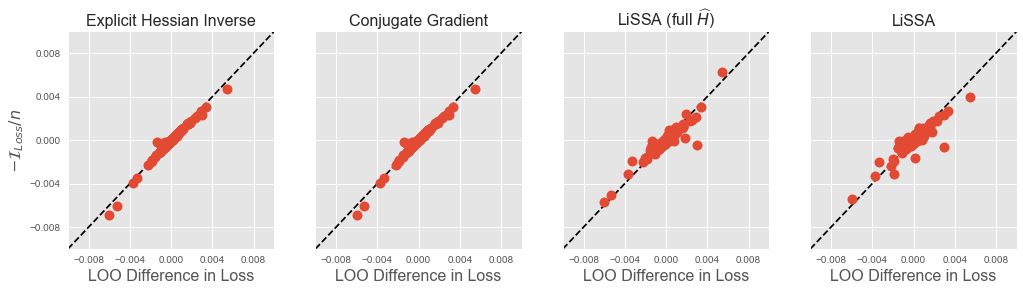

In [62]:
frame_trunc = 0.01
fig, axes = plt.subplots(
    1, 4, figsize=(17, 4), sharex='all', sharey='all')
# frame_trunc = np.percentile(loo_diff, trunc)
fontsize = 16
axes[0].plot(
    [-frame_trunc, frame_trunc],
    [-frame_trunc,frame_trunc], '--', color='black'
)
axes[0].plot(
    loo_diff[:, :], 
    I_loss_bf[:, :] / n_tr, 'o', markersize=10
)
axes[1].plot(
    [-frame_trunc, frame_trunc],
    [-frame_trunc,frame_trunc], '--', color='black'
)
axes[1].plot(
    loo_diff[:, :],
    I_loss_cg[:, :] / n_tr, 'o', markersize=10
)
axes[2].plot(
    [-frame_trunc, frame_trunc],
    [-frame_trunc,frame_trunc], '--', color='black'
)
axes[2].plot(
    loo_diff[:, :], 
    I_loss_lissa_deep[:, :] / n_tr, 'o', markersize=10
)
axes[3].plot(
    [-frame_trunc, frame_trunc],
    [-frame_trunc,frame_trunc], '--', color='black'
)
axes[3].plot(
    loo_diff[:, :], 
    I_loss_lissa_shallow[:, :] / n_tr, 'o', markersize=10
)

axes[0].update({
    'title': 'Influence 1 V.S. Numerical LOO',
    'xlabel': 'Influence I_loss/-n',
    'ylabel': 'Numerical LOO',
    'xlim': (-frame_trunc, frame_trunc),
    'ylim': (-frame_trunc, frame_trunc),
    'xticks':[-0.008, -0.004, 0, 0.004, 0.008],
    'yticks':[-0.008, -0.004, 0, 0.004, 0.008],
})
axes[1].set_xlim((-frame_trunc, frame_trunc))
axes[2].set_xlim((-frame_trunc, frame_trunc))
#axes[1].set_xticks([-150, -75, 0, 75, 150])
#axes[2].set_xticks([-150, -75, 0, 75, 150])
axes[0].set_xlabel('LOO Difference in Loss', fontsize=fontsize)
axes[1].set_xlabel('LOO Difference in Loss', fontsize=fontsize)
axes[2].set_xlabel('LOO Difference in Loss', fontsize=fontsize)
axes[3].set_xlabel('LOO Difference in Loss', fontsize=fontsize)
axes[0].set_ylabel(r'$-\mathcal{I}_{Loss} / n$', fontsize=fontsize)
axes[0].set_title('Explicit Hessian Inverse', fontsize=fontsize)
axes[1].set_title('Conjugate Gradient', fontsize=fontsize)
axes[2].set_title(r'LiSSA (full $\widehat{H}$)', fontsize=fontsize)
axes[3].set_title('LiSSA', fontsize=fontsize)


plt.savefig('tex/report/fig-ridge.eps', dpi=600, bbox_inches='tight')

array([[  6. ,   5. ,  85.1,  28. , 113.8,   3.5,  11.3,  94. ,   4.9,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,   0. ,   0. ,
          0. ,   0. ]])

(-200, 200)

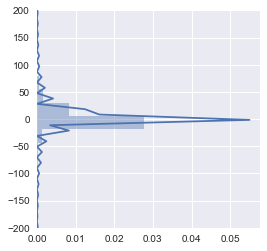

In [183]:
fig, ax = plt.subplots(
    1, 1, figsize=(4, 4))
sns.distplot(I_loss_bf[:, :].reshape(len(I_loss_cg),)/n_tr, 
             vertical=True, ax=ax)
ax.set_ylim((-200, 200))

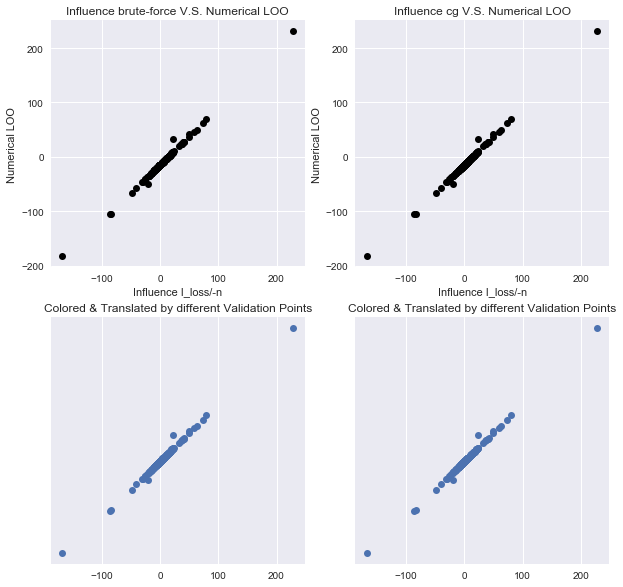

In [21]:
_ = compare_with_loo(
    [I_loss_bf[leave_indices,0:1], 
     I_loss_cg[leave_indices,0:1]], loo_diff, n_samples=n_tr)

In [10]:
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_bf[leave_indices, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_bf[leave_indices, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

Test Point 0 Correlation: 0.9215
Test Point 1 Correlation: 0.8930
Test Point 2 Correlation: 0.8603
Overall Correlation: 0.8946
